### Utilizando strides 2 e 32

In [1]:
import torch
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from models import Decoder

class EncoderDecoder(nn.Module):
    """Amostra ativações de um modelo ResNet do Pytorch e cria um decodificador."""

    def __init__(self, resnet_encoder, decoder_channels, num_classes):
        super().__init__()

        self.resnet_encoder = resnet_encoder
        encoder_channels_list = self.get_channels()
        self.decoder = Decoder(encoder_channels_list, decoder_channels)
        self.classification = nn.Conv2d(decoder_channels, num_classes, 3, padding=1)
        
    def get_features(self, x):
            
        features = []

        # stride 2
        re = self.resnet_encoder
        x = re.conv1(x)
        x = re.bn1(x)
        x = re.relu(x)
        features.append(x)

        # stride 4
        x = re.maxpool(x)
        x = re.layer1(x)

        # stride 8
        x = re.layer2(x)

        # stride 16
        x = re.layer3(x)

        # stride 32
        x = re.layer4(x)
        features.append(x)

        return features

    def get_channels(self):

        re = self.resnet_encoder
        # Armazena se o modelo estava em modo treinamento
        training = re.training
        re.eval()

        x = torch.zeros(1, 3, 224, 224)
        with torch.no_grad():
            features = self.get_features(x)
        encoder_channels_list = [f.shape[1] for f in features]

        # Volta para treinamento
        if training:
            re.train()

        return encoder_channels_list
        
    def forward(self, x):
        in_shape = x.shape[-2:]
        features = self.get_features(x)
        x = self.decoder(features)

        if x.shape[-2:]!=in_shape:
            x = F.interpolate(x, size=in_shape, mode="nearest")

        # A camada de classificação poderia estar antes da interpolação, o que
        # reduziria o custo computacional mas possivelmente levaria a segmentações
        # menos detalhadas
        x = self.classification(x)

        return x

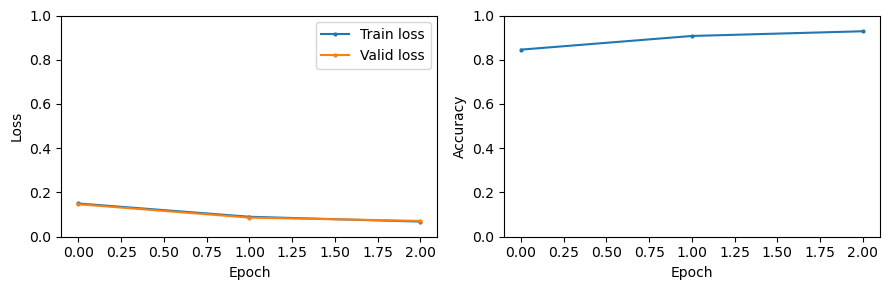

In [2]:
import train

torch.cuda.empty_cache()

params = {
    'bs_train':8,
    'bs_valid':2,
    'num_epochs':3,
    'lr':0.01,
    'weight_decay':1e-3,
    'resize_size':384,  
    'seed':0
}

encoder = resnet18(weights=ResNet18_Weights.DEFAULT)
model = EncoderDecoder(encoder, decoder_channels=64, num_classes=2)
ds_train, ds_valid, logger = train.train(model, **params)

In [3]:
import matplotlib.pyplot as plt
import dataset

checkpoint = torch.load('../data/checkpoints/checkpoint.pt', map_location='cpu')
checkpoint.keys()

dict_keys(['params', 'model', 'optim', 'sched', 'logger'])

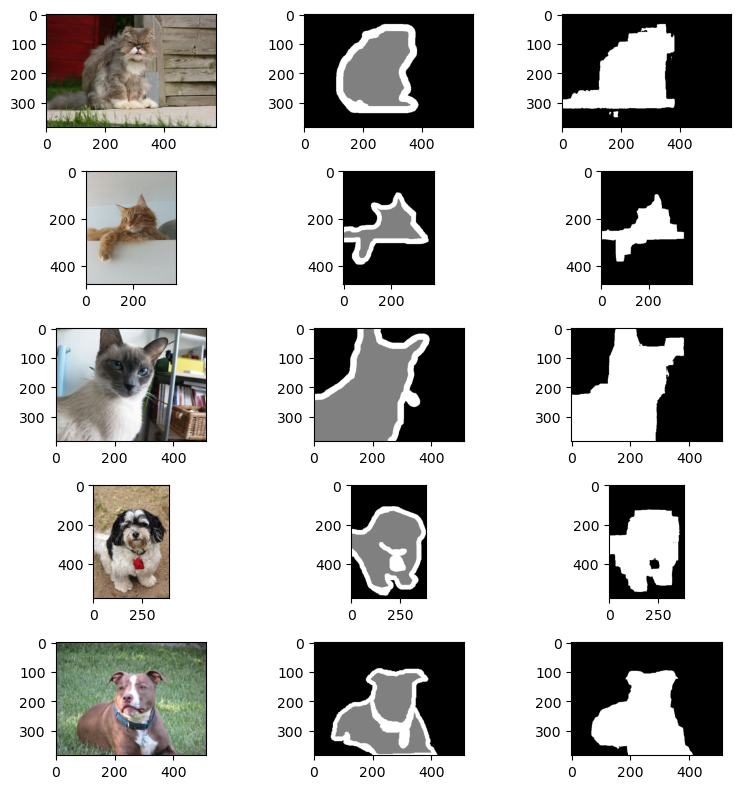

In [4]:
fig, axs = plt.subplots(5, 3, figsize=(8,8))
for idx in range(5):
    img, target = ds_valid[idx]
    with torch.no_grad():
        scores = model(img.unsqueeze(0))
    pred = torch.argmax(scores, dim=1)[0]
    axs[idx,0].imshow(dataset.unormalize(img))
    axs[idx,1].imshow(target, 'gray')
    axs[idx,2].imshow(pred, 'gray')
plt.tight_layout()

In [5]:
checkpoint["logger"]

[(0, 0.1502346396446228, 0.14673267304897308, 0.8456906676292419),
 (1, 0.09021268039941788, 0.08628435432910919, 0.9075238108634949),
 (2, 0.06827792525291443, 0.07140506058931351, 0.9287602305412292)]